# Applied Data Science Capstone Notebook - Select suitable location for The Tech Museum
Scrape Wikipedia using Beautifulsoup and use Foursquare API for location information

### First import the python libraries

In [1]:
!pip install geocoder
!pip install folium

import pandas as pd
from bs4 import BeautifulSoup
import requests
from geopy.geocoders import Nominatim
from urllib.request import Request
import folium
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as pp
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score

     |████████████████████████████████| 102kB 15.2MB/s ta 0:00:01
     |████████████████████████████████| 102kB 8.0MB/s ta 0:00:011


### Define Foursquare Credentials and Version

In [2]:
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = '20200522'

### Define function for getting details from a specific category and specific location

In [3]:
def getCategoryDf(category, latitudes, longitudes, radius=11200):
    
    venues_list=[]
    for lat, lng in zip(latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            category,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            200)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except KeyError:
            return(pd.DataFrame())
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            category, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    if nearby_venues.empty:
        return pd.DataFrame()
    
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Use BeautifulSoup to build the table containing largest cities in US

In [4]:
headers = requests.utils.default_headers()
headers.update({ 'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'})

url = "https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population"
req = requests.get(url, headers)
soup = BeautifulSoup(req.content, 'html.parser')
tables = soup.find_all("table", class_="wikitable")

table_number = 0
df_cities = pd.DataFrame()

for table in tables:
    table_number = table_number + 1

    if table_number == 2:
        cities = []
        urls = []
        latitudes = []
        longitudes = []
        populations = []
        densities = []
        areas = []
        
        row_number = 1
        
        rows = table.find_all('tr')
        for row in rows:
            if row_number > 11:
                continue
            row_number = row_number + 1
            fields = row.find_all('td')
            
            field_number = 1
            for field in fields:
                if field_number == 2:
                    cities.append(field.find("a")['title'])
                    urls.append('https://en.wikipedia.org/' + field.find("a")['href'])
                if field_number == 4:
                    populations.append(int(field.text.replace('\n', '').replace(',', '')))
                if field_number == 7:
                    areas.append(field.text.replace('\n', ''))
                if field_number == 9:
                    densities.append(field.text.replace('\n', ''))
                if field_number == 11:
                    latitudes.append(float(field.text.split(' ')[6].replace(';','')))
                    longitudes.append(float(field.text.split(' ')[7].replace('\ufeff', '')))

                field_number = field_number + 1


df_cities['city'] = cities
df_cities['url'] = urls
df_cities['population'] = populations
df_cities['density'] = densities
df_cities['area'] = areas
df_cities['latitude'] = latitudes
df_cities['longitude'] = longitudes

df_cities

,city,url,population,density,area,latitude,longitude
0,New York City,https://en.wikipedia.org//wiki/New_York_City,8336817,"28,317/sq mi",301.5 sq mi,40.6635,-73.9387
1,Los Angeles,https://en.wikipedia.org//wiki/Los_Angeles,3979576,"8,484/sq mi",468.7 sq mi,34.0194,-118.4108
2,Chicago,https://en.wikipedia.org//wiki/Chicago,2693976,"11,900/sq mi",227.3 sq mi,41.8376,-87.6818
3,Houston,https://en.wikipedia.org//wiki/Houston,2320268,"3,613/sq mi",637.5 sq mi,29.7866,-95.3909
4,"Phoenix, Arizona","https://en.wikipedia.org//wiki/Phoenix,_Arizona",1680992,"3,120/sq mi",517.6 sq mi,33.5722,-112.0901
5,Philadelphia,https://en.wikipedia.org//wiki/Philadelphia,1584064,"11,683/sq mi",134.2 sq mi,40.0094,-75.1333
6,San Antonio,https://en.wikipedia.org//wiki/San_Antonio,1547253,"3,238/sq mi",461.0 sq mi,29.4724,-98.5251
7,San Diego,https://en.wikipedia.org//wiki/San_Diego,1423851,"4,325/sq mi",325.2 sq mi,32.8153,-117.1350
8,Dallas,https://en.wikipedia.org//wiki/Dallas,1343573,"3,866/sq mi",340.9 sq mi,32.7933,-96.7665
9,"San Jose, California","https://en.wikipedia.org//wiki/San_Jose,_Calif...",1021795,"5,777/sq mi",177.5 sq mi,37.2967,-121.8189


### find points to investigate (using circle equation)

In [5]:
radius = 0.15
angle_change = 0.8
area_list = []

for idx, row in df_cities.iterrows():
    angle = 0
    areas = np.zeros((2, 9))
    city_lat = row['latitude']
    city_lon = row['longitude']

    for i in range(8):
        areas[0, i] = (city_lat + (radius * math.cos(angle)) * 0.9)
        areas[1, i] = city_lon + (radius * math.sin(angle))
        angle = angle + angle_change

    areas[0, 8] = city_lat
    areas[1, 8] = city_lon

    area_list.append(areas)

df_cities['areas'] = area_list

df_cities

,city,url,population,density,area,latitude,longitude,areas
0,New York City,https://en.wikipedia.org//wiki/New_York_City,8336817,"28,317/sq mi",301.5 sq mi,40.6635,-73.9387,"[[40.7985, 40.75755540576186, 40.6595580644893..."
1,Los Angeles,https://en.wikipedia.org//wiki/Los_Angeles,3979576,"8,484/sq mi",468.7 sq mi,34.0194,-118.4108,"[[34.154399999999995, 34.11345540576186, 34.01..."
2,Chicago,https://en.wikipedia.org//wiki/Chicago,2693976,"11,900/sq mi",227.3 sq mi,41.8376,-87.6818,"[[41.9726, 41.931655405761866, 41.833658064489..."
3,Houston,https://en.wikipedia.org//wiki/Houston,2320268,"3,613/sq mi",637.5 sq mi,29.7866,-95.3909,"[[29.9216, 29.880655405761868, 29.782658064489..."
4,"Phoenix, Arizona","https://en.wikipedia.org//wiki/Phoenix,_Arizona",1680992,"3,120/sq mi",517.6 sq mi,33.5722,-112.0901,"[[33.7072, 33.666255405761866, 33.568258064489..."
5,Philadelphia,https://en.wikipedia.org//wiki/Philadelphia,1584064,"11,683/sq mi",134.2 sq mi,40.0094,-75.1333,"[[40.1444, 40.10345540576186, 40.0054580644893..."
6,San Antonio,https://en.wikipedia.org//wiki/San_Antonio,1547253,"3,238/sq mi",461.0 sq mi,29.4724,-98.5251,"[[29.607400000000002, 29.566455405761868, 29.4..."
7,San Diego,https://en.wikipedia.org//wiki/San_Diego,1423851,"4,325/sq mi",325.2 sq mi,32.8153,-117.1350,"[[32.9503, 32.909355405761865, 32.811358064489..."
8,Dallas,https://en.wikipedia.org//wiki/Dallas,1343573,"3,866/sq mi",340.9 sq mi,32.7933,-96.7665,"[[32.9283, 32.887355405761866, 32.789358064489..."
9,"San Jose, California","https://en.wikipedia.org//wiki/San_Jose,_Calif...",1021795,"5,777/sq mi",177.5 sq mi,37.2967,-121.8189,"[[37.4317, 37.390755405761865, 37.292758064489..."


### Create a map of the cities included in the report - population size determines marker size

In [6]:
# create map with the cities included in the report
map_cities = folium.Map(location=[38.2700, -100.8603], zoom_start=5.2)

# add markers to map
for lat, lng, city, pop in zip(df_cities['latitude'], df_cities['longitude'], df_cities['city'], df_cities['population']):
    label = folium.Popup(city, parse_html=True)
    if pop < 2500000:
        folium.CircleMarker(
            [lat, lng],
            radius=(int(pop) / 500000) + 5,
            popup=label,
            fill=True,
            fill_color='#0000ee',
            fill_opacity=0.7,
            parse_html=False).add_to(map_cities)  
    else:
        folium.CircleMarker(
            [lat, lng],
            radius=(int(pop) / 500000) + 5,
            popup=label,
            fill=True,
            fill_color='#0000ee',
            fill_opacity=0.7,
            parse_html=False).add_to(map_cities)  

    
map_cities

### New York City map of coordinates to investigate

In [7]:
city_coordinates = df_cities['areas'][0]

map_city = folium.Map(location=[city_coordinates[0, 8], city_coordinates[1, 8]], zoom_start=11)

# add markers to map
for i in range(9):
    label = folium.Popup(city, parse_html=True)
    folium.CircleMarker(
        [city_coordinates[0, i], city_coordinates[1, i]],
        radius=120,
        popup=label,
        fill=True,
        fill_color='#eeeeee',
        fill_opacity=0.1,
        parse_html=False).add_to(map_city)  


In [8]:
map_city

### Find out if there is already a science museum in locations - build new dataframe with locations without museums

In [9]:
category = '4bf58dd8d48988d191941735'
cities = []
lat = []
lon = []
valid = []
num_museums = []

df_valid_locations = pd.DataFrame()

for idx, row in df_cities.iterrows():
    city_coordinates = row['areas']

    for i in range(city_coordinates.shape[1]):
        cityMuseumDf = getCategoryDf(category, [city_coordinates[0, i]], [city_coordinates[1, i]])
        cities.append(row['city'])
        lat.append(city_coordinates[0, i])
        lon.append(city_coordinates[1, i])

        num_museums.append(len(cityMuseumDf.index))
        
        if cityMuseumDf.empty:
            valid.append(1)
        else:
            valid.append(0)

df_valid_locations['city'] = cities
df_valid_locations['latitude'] = lat
df_valid_locations['longitude'] = lon
df_valid_locations['valid'] = valid
df_valid_locations['museum_count'] = num_museums

df_valid_locations

,city,latitude,longitude,valid,museum_count
0,New York City,40.798500,-73.938700,0,22
1,New York City,40.757555,-73.831097,0,4
2,New York City,40.659558,-73.788764,0,5
3,New York City,40.563952,-73.837381,0,1
4,New York City,40.528730,-73.947456,1,0
5,New York City,40.575258,-74.052220,1,0
6,New York City,40.675312,-74.088125,0,12
7,New York City,40.768201,-74.033390,0,30
8,New York City,40.663500,-73.938700,0,15
9,Los Angeles,34.154400,-118.410800,0,3


### Add restaurant information to dataset

In [10]:
category = '4d4b7105d754a06374d81259'
num_restaurants = []

for idx, row in df_cities.iterrows():
    city_coordinates = row['areas']

    for i in range(city_coordinates.shape[1]):
        cityMuseumDf = getCategoryDf(category, [city_coordinates[0, i]], [city_coordinates[1, i]], 533)
        num_restaurants.append(len(cityMuseumDf.index))

df_valid_locations['restaurant_count'] = num_restaurants

df_valid_locations

,city,latitude,longitude,valid,museum_count,restaurant_count
0,New York City,40.798500,-73.938700,0,22,88
1,New York City,40.757555,-73.831097,0,4,100
2,New York City,40.659558,-73.788764,0,5,3
3,New York City,40.563952,-73.837381,0,1,0
4,New York City,40.528730,-73.947456,1,0,0
5,New York City,40.575258,-74.052220,1,0,0
6,New York City,40.675312,-74.088125,0,12,3
7,New York City,40.768201,-74.033390,0,30,26
8,New York City,40.663500,-73.938700,0,15,14
9,Los Angeles,34.154400,-118.410800,0,3,10


### Add public transportation information to dataset

In [11]:
bus_category = '52f2ab2ebcbc57f1066b8b4f'
tram_category = '52f2ab2ebcbc57f1066b8b51'
train_category = '4bf58dd8d48988d129951735'

num_transports = []
transport_count = 0

for idx, row in df_cities.iterrows():
    city_coordinates = row['areas']

    for i in range(city_coordinates.shape[1]):
        cityTransportDf = getCategoryDf(bus_category, [city_coordinates[0, i]], [city_coordinates[1, i]], 533)
        transport_count = len(cityTransportDf.index)
        cityTransportDf = getCategoryDf(tram_category, [city_coordinates[0, i]], [city_coordinates[1, i]], 533)
        transport_count = transport_count + len(cityTransportDf.index)
        cityTransportDf = getCategoryDf(train_category, [city_coordinates[0, i]], [city_coordinates[1, i]], 533)
        transport_count = transport_count + len(cityTransportDf.index)
        
        num_transports.append(transport_count)

df_valid_locations['transportation_count'] = num_transports

df_valid_locations

,city,latitude,longitude,valid,museum_count,restaurant_count,transportation_count
0,New York City,40.798500,-73.938700,0,22,88,20
1,New York City,40.757555,-73.831097,0,4,100,22
2,New York City,40.659558,-73.788764,0,5,3,0
3,New York City,40.563952,-73.837381,0,1,0,0
4,New York City,40.528730,-73.947456,1,0,0,0
5,New York City,40.575258,-74.052220,1,0,0,0
6,New York City,40.675312,-74.088125,0,12,3,0
7,New York City,40.768201,-74.033390,0,30,26,6
8,New York City,40.663500,-73.938700,0,15,14,1
9,Los Angeles,34.154400,-118.410800,0,3,10,0


### Add college and university information to dataset

In [12]:
category = '4d4b7105d754a06372d81259'
num_institutions = []

for idx, row in df_cities.iterrows():
    city_coordinates = row['areas']

    for i in range(city_coordinates.shape[1]):
        cityInstDf = getCategoryDf(category, [city_coordinates[0, i]], [city_coordinates[1, i]], 533)
        num_institutions.append(len(cityInstDf.index))

df_valid_locations['institution_count'] = num_institutions

df_valid_locations

,city,latitude,longitude,valid,museum_count,restaurant_count,transportation_count,institution_count
0,New York City,40.798500,-73.938700,0,22,88,20,9
1,New York City,40.757555,-73.831097,0,4,100,22,7
2,New York City,40.659558,-73.788764,0,5,3,0,0
3,New York City,40.563952,-73.837381,0,1,0,0,0
4,New York City,40.528730,-73.947456,1,0,0,0,0
5,New York City,40.575258,-74.052220,1,0,0,0,0
6,New York City,40.675312,-74.088125,0,12,3,0,0
7,New York City,40.768201,-74.033390,0,30,26,6,4
8,New York City,40.663500,-73.938700,0,15,14,1,5
9,Los Angeles,34.154400,-118.410800,0,3,10,0,2


### Create data for ML for finding best location (most like popular locations)

In [28]:
rest_normal = []
transp_normal = []
inst_normal = []
pop_normal = []

xInValid = df_valid_locations[df_valid_locations['valid'] == 0]

for idx, row in xInValid.iterrows():
    # Do feature scaling of counts
    rest_normal.append((row['restaurant_count'] - xInValid['restaurant_count'].min()) / (xInValid['restaurant_count'].max() - xInValid['restaurant_count'].min()))
    transp_normal.append((row['transportation_count'] - xInValid['transportation_count'].min()) / (xInValid['transportation_count'].max() - xInValid['transportation_count'].min()))
    inst_normal.append((row['institution_count'] - xInValid['institution_count'].min()) / (xInValid['institution_count'].max() - xInValid['institution_count'].min()))
    pop_normal.append((df_cities[df_cities['city'] == row['city']]['population'].iloc[0] - df_cities['population'].min()) / (df_cities['population'].max() - df_cities['population'].min()))

### Create a densely connected neural network with linear output, train with SGD, 15 epochs

In [69]:

x = np.zeros((len(xInValid.index), 4))

x[:,0] = rest_normal
x[:,1] = transp_normal
x[:,2] = inst_normal
x[:,3] = pop_normal

dense_model = keras.models.Sequential()
dense_model.add(layers.Dense(5, activation="relu", input_shape=(4,)))
dense_model.add(layers.Dense(1, activation="linear"))

opt = keras.optimizers.SGD(lr=0.01, momentum=0.9)

dense_model.compile(optimizer=opt, loss='mse')
dense_model.fit(x, xInValid['museum_count'], batch_size=16, epochs=15)

dense_model.summary()

Epoch 1/150
65/65 [==============================] - 6s 98ms/sample - loss: 6.7172
Epoch 2/150
65/65 [==============================] - 0s 1ms/sample - loss: 6.0115
Epoch 3/150
65/65 [==============================] - 0s 1ms/sample - loss: 5.4143
Epoch 4/150
65/65 [==============================] - 0s 1ms/sample - loss: 5.6094
Epoch 5/150
65/65 [==============================] - 0s 1ms/sample - loss: 5.5517
Epoch 6/150
65/65 [==============================] - 0s 972us/sample - loss: 5.3103
Epoch 7/150
65/65 [==============================] - 2s 35ms/sample - loss: 5.3878
Epoch 8/150
65/65 [==============================] - 0s 916us/sample - loss: 5.4041
Epoch 9/150
65/65 [==============================] - 0s 1ms/sample - loss: 5.3854
Epoch 10/150
65/65 [==============================] - 0s 958us/sample - loss: 5.3309
Epoch 11/150
65/65 [==============================] - 0s 1ms/sample - loss: 5.2992
Epoch 12/150
65/65 [==============================] - 0s 936us/sample - loss: 5.2655
Epo

### Use the dense model to predict how many museums there should be in each locality with no museums

In [15]:
xValid = df_valid_locations[df_valid_locations['valid'] == 1]

rest_normal = []
transp_normal = []
inst_normal = []
pop_normal = []

for idx, row in xValid.iterrows():
    # Do feature scaling of counts
    rest_normal.append((row['restaurant_count'] - xValid['restaurant_count'].min()) / (xValid['restaurant_count'].max() - xValid['restaurant_count'].min()))
    transp_normal.append((row['transportation_count'] - xValid['transportation_count'].min()) / (xValid['transportation_count'].max() - xValid['transportation_count'].min()))
    inst_normal.append((row['institution_count'] - xValid['institution_count'].min()) / (xValid['institution_count'].max() - xValid['institution_count'].min()))
    pop_normal.append((df_cities[df_cities['city'] == row['city']]['population'].iloc[0] - df_cities['population'].min()) / (df_cities['population'].max() - df_cities['population'].min()))
    
x_pred = np.zeros((len(xValid.index), 4))

x_pred[:,0] = rest_normal
x_pred[:,1] = transp_normal
x_pred[:,2] = inst_normal
x_pred[:,3] = pop_normal

xValid['dense'] = dense_model.predict(x_pred)

xValid

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,city,latitude,longitude,valid,museum_count,restaurant_count,transportation_count,institution_count,dense
4,New York City,40.528730,-73.947456,1,0,0,0,0,5.942764
5,New York City,40.575258,-74.052220,1,0,0,0,0,5.942764
22,Chicago,41.702830,-87.690556,1,0,1,1,1,4.965051
27,Houston,29.921600,-95.390900,1,0,0,0,0,3.471725
32,Houston,29.698358,-95.504420,1,0,0,0,0,3.471725
33,Houston,29.798412,-95.540325,1,0,22,0,1,4.829288
34,Houston,29.891301,-95.485590,1,0,1,0,0,3.538155
36,"Phoenix, Arizona",33.707200,-112.090100,1,0,0,0,0,3.213642
43,"Phoenix, Arizona",33.676901,-112.184790,1,0,0,0,1,3.429383
44,"Phoenix, Arizona",33.572200,-112.090100,1,0,3,0,0,3.385561


### Create a linear regression model

In [19]:
linear_model = LinearRegression()
linear_model.fit(x, xInValid['museum_count'])

0.1327352668970364


### Display r2 score for the two models

In [62]:
print('Dense')
print(r2_score(xInValid['museum_count'], dense_model.predict(x)))

print('Linear')
print(r2_score(xInValid['museum_count'], linear_model.predict(x)))

Dense
0.030050167171390085
Linear
0.1327352668970364


### Use the linear regression model to predict how many museums there should be in each locality with no museums

In [21]:
xValid['linear'] = linear_model.predict(x_pred)

xValid

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,city,latitude,longitude,valid,museum_count,restaurant_count,transportation_count,institution_count,dense,linear
4,New York City,40.528730,-73.947456,1,0,0,0,0,5.942764,13.218598
5,New York City,40.575258,-74.052220,1,0,0,0,0,5.942764,13.218598
22,Chicago,41.702830,-87.690556,1,0,1,1,1,4.965051,6.145692
27,Houston,29.921600,-95.390900,1,0,0,0,0,3.471725,5.726592
32,Houston,29.698358,-95.504420,1,0,0,0,0,3.471725,5.726592
33,Houston,29.798412,-95.540325,1,0,22,0,1,4.829288,0.015684
34,Houston,29.891301,-95.485590,1,0,1,0,0,3.538155,5.418541
36,"Phoenix, Arizona",33.707200,-112.090100,1,0,0,0,0,3.213642,4.930544
43,"Phoenix, Arizona",33.676901,-112.184790,1,0,0,0,1,3.429383,5.996766
44,"Phoenix, Arizona",33.572200,-112.090100,1,0,3,0,0,3.385561,4.006390


### Find the top 3 candidates from shallow dense NN - disqualify areas with no restaurants

In [22]:
print('Dense model top 3 candidate locations:')
xValid[xValid['restaurant_count'] > 0].sort_values('dense', ascending=False).head(3)


Dense model top 3 candidate locations:


,city,latitude,longitude,valid,museum_count,restaurant_count,transportation_count,institution_count,dense,linear
61,San Antonio,29.577101,-98.619790,1,0,4,0,10,5.263879,14.194014
22,Chicago,41.702830,-87.690556,1,0,1,1,1,4.965051,6.145692
33,Houston,29.798412,-95.540325,1,0,22,0,1,4.829288,0.015684


### Show the top pick from the shallow densely connected NN on a map - disqualify areas with no restaurants

In [23]:
location = xValid[xValid['restaurant_count'] > 0].sort_values('dense', ascending=False).head(1)
map_city = folium.Map(location=[location['latitude'], location['longitude']], zoom_start=14)

# add marker to map
folium.CircleMarker(
    [location['latitude'], location['longitude']],
    radius=30,
    fill=True,
    fill_color='#0000ee',
    fill_opacity=0.3,
    parse_html=False).add_to(map_city)  

map_city

### Find the 3 top candidates from the linear regression model

In [24]:
print('Linear regression model top 3 candidate locations:')
xValid[xValid['restaurant_count'] > 0].sort_values('linear', ascending=False).head(3)

Linear regression model top 3 candidate locations:


,city,latitude,longitude,valid,museum_count,restaurant_count,transportation_count,institution_count,dense,linear
61,San Antonio,29.577101,-98.619790,1,0,4,0,10,5.263879,14.194014
22,Chicago,41.702830,-87.690556,1,0,1,1,1,4.965051,6.145692
34,Houston,29.891301,-95.485590,1,0,1,0,0,3.538155,5.418541


### Show the top pick from linear regression on a map

In [25]:
location = xValid[xValid['restaurant_count'] > 0].sort_values('linear', ascending=False).head(1)
map_city = folium.Map(location=[location['latitude'], location['longitude']], zoom_start=14)

# add marker to map
folium.CircleMarker(
    [location['latitude'], location['longitude']],
    radius=30,
    fill=True,
    fill_color='#0000ee',
    fill_opacity=0.3,
    parse_html=False).add_to(map_city)  

map_city

### Show a bar chart of the amount of valid locations in each city

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


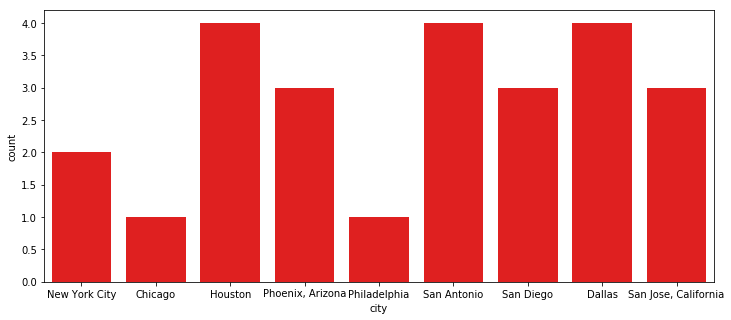

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

xInvalid = df_valid_locations[df_valid_locations['valid'] == 1]
xInvalid['count'] = xInvalid.groupby('city').count
fig, ax = plt.subplots(figsize=(12, 5))
sns.countplot(xInvalid['city'],label="count", ax=ax, color='red')

plt.show()